# Florida Course Enrollment - datagen
This program creates two files for later analysis of Statewide K12 course enrollment
- completers.csv: a listing of raw graduation demographic data by school.
- takers.csv: enrollment numbers by course number for each FL K12 school

The source data can be found on the [FLDOE Publications and Reports page](http://www.fldoe.org/accountability/data-sys/edu-info-accountability-services/pk-12-public-school-data-pubs-reports/students.stml):
- Course Enrollment by School, Survey 3 2015-16 (5 .xls files)
- High School Completers, by school (.xls file)

The [FL Course Code Directory](http://www.fldoe.org/core/fileparse.php/7746/urlt/1617CCD-Basic9-12.pdf) lists each course, its numeric code, as well as credit and certification information.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### Course enrollment data (i.e., "takers")

In [2]:
# replacing the 5 files' paths below with the URLs on the FLDOE page (linked above)
# also works, but takes longer to remotely pull the data
df1 = pd.read_excel('./FLDOEfiles/CRSENROLL15163Alachua-Columbia.xls', skiprows=4, header=0)
df2 = pd.read_excel('./FLDOEfiles/CRSENROLL15163Dade-Highlands.xls', skiprows=4, header=0)
df3 = pd.read_excel('./FLDOEfiles/CRSENROLL15163Hills-Okeechobee.xls', skiprows=4, header=0)
df4 = pd.read_excel('./FLDOEfiles/CRSENROLL15163Orange-Pinellas.xls', skiprows=4, header=0)
df5 = pd.read_excel('./FLDOEfiles/CRSENROLL15163Polk-UF.xls', skiprows=4, header=0)

# combine into one
enrollment = df1.append(df2, ignore_index=True)\
.append(df3, ignore_index=True)\
.append(df4, ignore_index=True)\
.append(df5, ignore_index=True)

# clean up column headings (e.g., "Course Name" to "Course_Name"
cols = enrollment.columns
cols = cols.map(lambda x: x.replace('#', 'NUMBER') if isinstance(x, (str or unicode)) else x)
enrollment.columns = cols

cols1 = enrollment.columns
cols1 = cols1.map(lambda x: x.replace(' ', '_') if isinstance(x, (str or unicode)) else x)
enrollment.columns = cols1

# create a unique school identifier (since school names aren't) "site" = districtName_schoolNumber
enrollment.insert(0, "SITE", enrollment.DISTRICT_NAME.astype(str).str.cat(enrollment.SCHOOL_NUMBER.astype(str), sep='_'))

# clean up enrollment data
enrollment.rename(index=str, columns={"DISTRICT_NAME": "DISTRICT"}, inplace=True)
enrollment.fillna(0, inplace=True);
enrollment = enrollment[enrollment.ENROLLMENT != "*"] # * = fewer than 10 enrolled
enrollment.insert(7,"TAKERS", enrollment.ENROLLMENT.astype(int))
enrollment.drop('ENROLLMENT', inplace=True, axis=1)

enrollment.insert(5,"COURSE_NUM", enrollment.COURSE_NUMBER.astype(str))
enrollment.drop('COURSE_NUMBER', inplace=True, axis=1)

#output to csv
enrollment.to_csv('takers.csv')

### Graduation data (e.i., high school "completers")

In [3]:
completers = pd.read_csv('./FLDOEfiles/2014-15CompletersSchool2.csv', header=0)

cols2 = completers.columns
cols2 = cols2.map(lambda x: x.replace(' ', '_') if isinstance(x, (str or unicode)) else x)
completers.columns = cols2

completers.columns = map(str.upper, completers.columns)

# create a unique school identifier (since school names aren't) "site" = districtName_schoolNumber
completers.insert(0,"SITE", completers.DISTRICT.astype(str).str.cat(completers.SCHOOL_NUMBER.astype(int).astype(str), sep='_'))

# clean up completers data
completers.fillna(0, inplace=True);
completers = completers[completers.TOTAL != "*"]
completers.insert(4,"COMPLETERS", completers.TOTAL.astype(int))
completers = completers.drop(['TOTAL'], axis=1)

# convert completers data to percent
for x in range(6, 22):
    label = completers.columns[x]
    LABEL = "PCT_" + label.upper()
    completers.insert(x, LABEL, completers[label].astype(int)/completers['COMPLETERS'].astype(int))
    completers.drop(label, inplace=True, axis=1)

#output to csv
completers.to_csv('completers.csv')

## A quick test

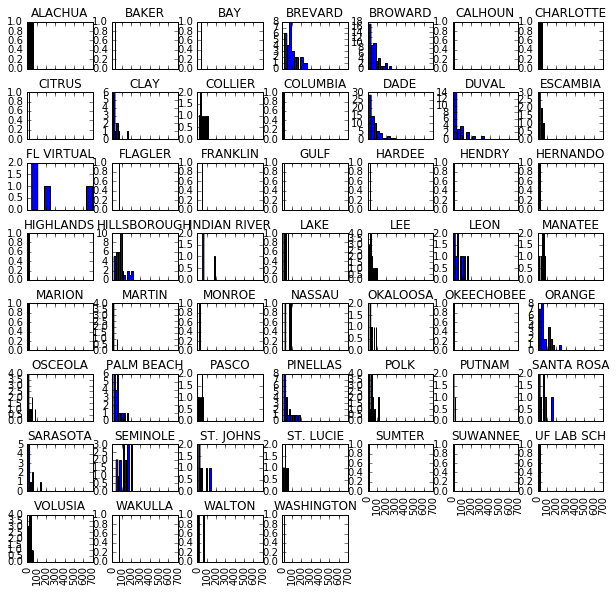

In [4]:
# Physics 1 enrollment
data1 = pd.read_csv('takers.csv', header=0)
data1.query('COURSE_NUM == "2003380" \
    or COURSE_NUM == "2003390" \
    ').hist(by="DISTRICT", column="TAKERS", sharex=True, figsize=(10,10));

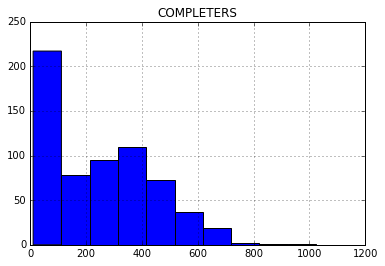

In [5]:
# graduating class sizes
data2 = pd.read_csv('completers.csv', header=0)
data2.query('GRADE == 12').hist(column="COMPLETERS");

## Next up ...
- put all fields as appropriate data types, maybe upon read?
- reduce number of lines of code